In [2]:
pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


# Import module

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import preprocessor as p

from transformers import XLMModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [4]:
MAX_LEN = 256

# Load data & preprocessing

In [5]:
#long_covid
df = pd.read_csv('long_covid1003_unique.csv', encoding= 'unicode_escape')
print(f'Total shape : {df.shape}\nLabel distribution : \n\t0:{df.shape[0]-df.label.values.sum()}\n\t1:{df.label.values.sum()}')
df, val_df = train_test_split(df, test_size = 0.2, stratify = df.label, random_state = 42 )
val_df, test_df = train_test_split(val_df, test_size = 0.5, stratify = val_df.label, random_state = 42 )
print('Split shape : ',df.shape, val_df.shape, test_df.shape)

Total shape : (2927, 3)
Label distribution : 
	0:566
	1:2361
Split shape :  (2341, 3) (293, 3) (293, 3)


In [6]:
df.label.values.sum()

1888

In [7]:
#df.tweet.values

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

In [9]:
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row, lemmatizer, stemmer):
    text = row['tweet']
    # text = text.strip('\xa0')
    text = p.clean(text)
    tokenization = nltk.word_tokenize(text)     
    tokenization = [w for w in tokenization if not w in stop_words]
    #   text = ' '.join([porter_stemmer.stem(w) for w in tokenization])
    #   text = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # text = re.sub(r'\([0-9]+\)', '', text).strip()    
    return text

In [10]:
df['tweet'] = df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
val_df['tweet'] = val_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
test_df['tweet'] = test_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)

In [11]:
train_sentences = df.tweet.values
val_sentences = val_df.tweet.values
test_sentences = test_df.tweet.values

train_labels = df.label.values
val_labels = val_df.label.values
test_labels = test_df.label.values
#print(train_sentences)

# RoBerta

In [12]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=False)
#tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=True)

In [13]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [14]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [15]:
print('Train token ids:\n',train_token_ids[0])
print('Train attention masks:\n', train_attention_masks[0])

Train token ids:
 tensor([    0,  6968,   769,  9161,     7,     5,  9240,  4488,  6793,   114,
           47,  2584,   198,    10, 17126, 26144,     9,   514,     7,  4076,
          148,     5,   183,    11,  1692,   334,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,    

In [16]:
batch_size = 64

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [3]:
#load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).cuda()
epochs = 20
#setting parameters of optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#load optimizer
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [4]:
total = [param.nelement() for param in model.parameters()]
print(f"Number of parameter:{sum(total)}\n and each layer is:{total}")

Number of parameter:124647170
 and each layer is:[38603520, 394752, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 

In [58]:
#learning rate scheduler(decay)
# 指數下降
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# # warm up 
# # 總訓練步數是批次數乘以Epoch數
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = total_steps*0.2, # 預熱步數，也可以設定為總步數的一部分，如total_steps*0.1
#                                             num_training_steps = total_steps)


In [22]:
#define accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#define precision_Score
def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, pred_flat)

#define recall_Score
def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, pred_flat)

#define f1_Score
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

#define roc_auc
def flat_roc_auc(preds, labels):
    labels_flat = labels.flatten()
    fpr, tpr, thresholds = roc_curve(labels_flat, preds)
    roc_auc = auc(fpr, tpr)
    return roc_auc
    #return roc_auc_score(labels_flat, pred_probs)
#Confusion matrix
def plot_confusion_matrix(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    cm = confusion_matrix(labels_flat, pred_flat)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [67]:
#prepare clean sets to store performance of each epoches
train_loss_set = []
val_loss_set = []
train_acc_set = []
val_acc_set = []
val_f1_set = []
val_auc_set = []
best_val_f1_score = 0.90
directory_path = ''


#training
for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss, train_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1].cpu().detach().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        loss.backward()
        optimizer.step()
        
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)

        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_tr_steps += 1
        
# learning rate scheduler        
    #     # warm up 
    #     scheduler.step()
    # after_lr = optimizer.param_groups[0]["lr"] 
    
# #     # Exponential    
#     before_lr = optimizer.param_groups[0]["lr"]
#     scheduler.step()
#     after_lr = optimizer.param_groups[0]["lr"]
    
#     print("Epoch %d: AdamW lr %.6f -> %.6f" % (_, before_lr, after_lr))
    
    train_acc_set.append(train_accuracy/nb_tr_steps)
    train_loss_set.append(tr_loss/nb_tr_steps)
    #print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
#evaluation
    model.eval()

    val_loss, eval_accuracy, eval_f1_score, eval_roc_auc = 0, 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        #move outputs to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #append loss and calculate accuracy
        val_loss += loss.item()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)   
        
        #calculate f1
        tmp_f1 = flat_f1(logits, label_ids)
        
        #calculate auc_roc_score
        probs = softmax(logits)[:,1]
        tmp_roc_auc = flat_roc_auc(probs, label_ids)
        
        #summarize metrics from each batch
        eval_accuracy += tmp_eval_accuracy
        eval_f1_score += tmp_f1
        eval_roc_auc += tmp_roc_auc
        nb_eval_steps += 1

    val_acc_set.append(eval_accuracy/nb_eval_steps)
    val_loss_set.append(val_loss/nb_eval_steps)
    val_f1_set.append(eval_f1_score/nb_eval_steps)
    val_auc_set.append(eval_roc_auc/nb_eval_steps)
    print("Validation loss: {}".format(val_loss/nb_tr_steps))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print("Validation F1_score: {}".format(eval_f1_score/nb_eval_steps))
    print("Validation AUC: {}".format(eval_roc_auc/nb_eval_steps))
    Validation_F1_score = (eval_f1_score/nb_eval_steps)
    if(Validation_F1_score >= best_val_f1_score):
        torch.save(model.state_dict(), 'RoBerta_base_best_model.ckpt')
        best_val_f1_score = Validation_F1_score
        print('Model Saved')

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.03570426638061936
Validation Accuracy: 0.860472972972973
Validation F1_score: 0.919296108163385
Validation AUC: 0.9469837690489864


Epoch:   5%|▌         | 1/20 [00:16<05:08, 16.25s/it]

Model Saved
Validation loss: 0.024916053221032426
Validation Accuracy: 0.9298141891891891
Validation F1_score: 0.9571169208738481
Validation AUC: 0.960772910664215


Epoch:  10%|█         | 2/20 [00:32<04:54, 16.35s/it]

Model Saved


Epoch:  15%|█▌        | 3/20 [00:48<04:35, 16.21s/it]

Validation loss: 0.02922709286212921
Validation Accuracy: 0.9096283783783784
Validation F1_score: 0.9427187453947887
Validation AUC: 0.9685432281084456
Validation loss: 0.02104405575507396
Validation Accuracy: 0.9423141891891891
Validation F1_score: 0.9649489181596126
Validation AUC: 0.9736952419561116


Epoch:  20%|██        | 4/20 [01:05<04:22, 16.39s/it]

Model Saved


Epoch:  25%|██▌       | 5/20 [01:21<04:04, 16.30s/it]

Validation loss: 0.02302466393322558
Validation Accuracy: 0.9181587837837839
Validation F1_score: 0.9472734516164614
Validation AUC: 0.9762249264423175


Epoch:  30%|███       | 6/20 [01:37<03:47, 16.23s/it]

Validation loss: 0.04503676375827274
Validation Accuracy: 0.8837837837837839
Validation F1_score: 0.9228219916394853
Validation AUC: 0.9733608018390628


Epoch:  35%|███▌      | 7/20 [01:53<03:30, 16.19s/it]

Validation loss: 0.030072369285531947
Validation Accuracy: 0.9423141891891891
Validation F1_score: 0.9640113153587752
Validation AUC: 0.9765953812692943
Validation loss: 0.034381246546635755
Validation Accuracy: 0.9445945945945946
Validation F1_score: 0.9649834855939143
Validation AUC: 0.972487681400725


Epoch:  40%|████      | 8/20 [02:10<03:15, 16.33s/it]

Model Saved


Epoch:  45%|████▌     | 9/20 [02:26<02:58, 16.24s/it]

Validation loss: 0.0409165401313756
Validation Accuracy: 0.9445945945945946
Validation F1_score: 0.9648107060304689
Validation AUC: 0.9756838210099079


Epoch:  50%|█████     | 10/20 [02:42<02:41, 16.17s/it]

Validation loss: 0.03687741979956627
Validation Accuracy: 0.9414695945945946
Validation F1_score: 0.9633112806460241
Validation AUC: 0.9712482445091141


Epoch:  55%|█████▌    | 11/20 [02:58<02:25, 16.14s/it]

Validation loss: 0.037312011964417795
Validation Accuracy: 0.9383445945945945
Validation F1_score: 0.9606182518940894
Validation AUC: 0.9637748845357541


Epoch:  60%|██████    | 12/20 [03:14<02:08, 16.12s/it]

Validation loss: 0.04980682722620062
Validation Accuracy: 0.9133445945945946
Validation F1_score: 0.9431830921022841
Validation AUC: 0.974340912710478
Validation loss: 0.040908825155851
Validation Accuracy: 0.9477195945945945
Validation F1_score: 0.968652275248479
Validation AUC: 0.9668447977143628


Epoch:  65%|██████▌   | 13/20 [03:31<01:53, 16.26s/it]

Model Saved


Epoch:  70%|███████   | 14/20 [03:47<01:37, 16.19s/it]

Validation loss: 0.04227782040834427
Validation Accuracy: 0.9204391891891891
Validation F1_score: 0.9486988025199979
Validation AUC: 0.9749545020197194


Epoch:  75%|███████▌  | 15/20 [04:03<01:20, 16.15s/it]

Validation loss: 0.06919995594669033
Validation Accuracy: 0.8962837837837838
Validation F1_score: 0.9315296200146335
Validation AUC: 0.9740491754622191
Validation loss: 0.034504215031660894
Validation Accuracy: 0.9508445945945946
Validation F1_score: 0.9695405617192897
Validation AUC: 0.9725486590703982


Epoch:  80%|████████  | 16/20 [04:19<01:05, 16.28s/it]

Model Saved


Epoch:  85%|████████▌ | 17/20 [04:35<00:48, 16.21s/it]

Validation loss: 0.0462894091332281
Validation Accuracy: 0.9360641891891891
Validation F1_score: 0.9593595090977965
Validation AUC: 0.975446787512005


Epoch:  90%|█████████ | 18/20 [04:51<00:32, 16.16s/it]

Validation loss: 0.07646696027871724
Validation Accuracy: 0.9056587837837838
Validation F1_score: 0.9381211477292682
Validation AUC: 0.9708062710236623


Epoch:  95%|█████████▌| 19/20 [05:07<00:16, 16.13s/it]

Validation loss: 0.0626988439141093
Validation Accuracy: 0.8891891891891891
Validation F1_score: 0.9262679149329636
Validation AUC: 0.9636642544251239
Validation loss: 0.02767599083332194
Validation Accuracy: 0.9570945945945946
Validation F1_score: 0.9733000016024871
Validation AUC: 0.97156846776412


Epoch: 100%|██████████| 20/20 [05:24<00:00, 16.22s/it]

Model Saved


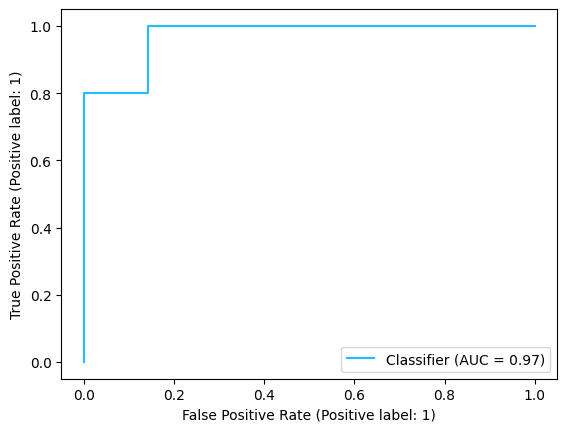

In [99]:
RocCurveDisplay.from_predictions(label_ids.flatten(), softmax(logits)[:,1], color='#20BEFF')

# Visualization

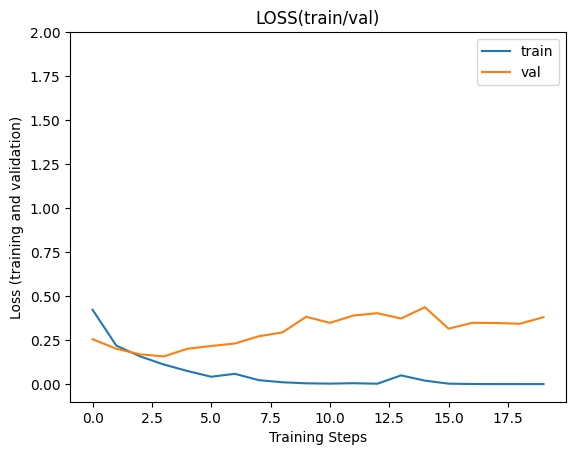

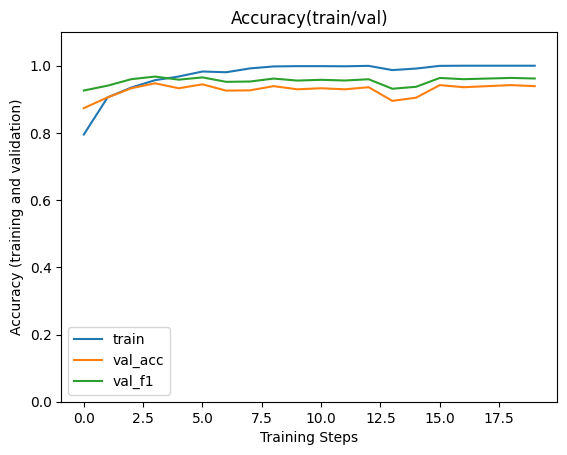

In [100]:
# Visualize training process

plt.figure('LOSS(train/val)')
plt.title('LOSS(train/val)')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([-0.1,2])
plt.plot(train_loss_set, label = 'train')
plt.plot(val_loss_set, label = 'val')
plt.legend()

plt.figure('Accuracy(train/val)')
plt.title('Accuracy(train/val)')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(train_acc_set, label = 'train')
plt.plot(val_acc_set, label = 'val_acc')
plt.plot(val_f1_set, label = 'val_f1')
plt.legend()

# Evaluation

In [68]:
# 載入模型
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))
model.to(device)
model.eval()

# 預測
preds = []
labels_list = []
probs_list = []  # 用於存儲正類概率

for batch in test_dataloader:
    input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds_batch = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        # 從logits取得正類的概率
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pos_probs_batch = probs[:, 1].cpu().numpy()
        
    preds.append(preds_batch)
    labels_list.append(labels_batch.cpu().numpy())
    probs_list.append(pos_probs_batch)

preds = np.concatenate(preds)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(probs_list)

# 計算準確度
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
# 使用正類的概率計算AUC
test_auc = roc_auc_score(labels, pos_probs)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Test Accuracy: 91.81%
Test Precision: 93.44%
Test Recall: 96.61%
Test F1-score: 95.00%
Test AUC: 96.59%


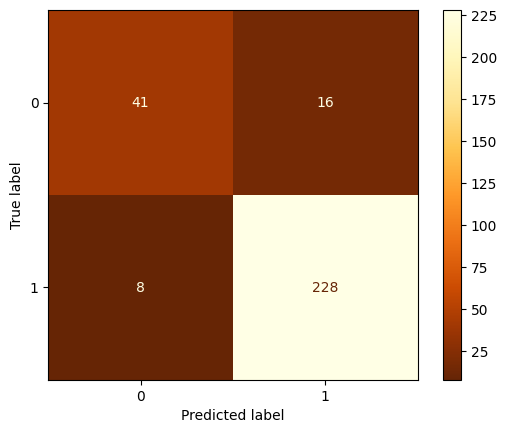

In [69]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [23]:
Roberta_ACC = [93.69, 92.43, 94.01, 91.17, 93.06]
Roberta_PRE = [93.69, 93.83, 96.98, 96.44, 92.16]
Roberta_REC = [94.51, 96.20, 94.94, 91.56, 99.16]
Roberta_F1  = [95.73, 95.00, 95.95, 93.94, 95.53]
Roberta_AUC = [97.73, 97.07, 97.81, 97.72, 98.29]
Roberta_TIME = [348, 347, 347, 346, 346]

print(f'acc:{sum(Roberta_ACC)/5:.2f}, std:{np.std(Roberta_ACC):.2f}')
print(f'precision:{sum(Roberta_PRE)/5:.2f}, std:{np.std(Roberta_PRE):.2f}')
print(f'recall:{sum(Roberta_REC)/5:.2f}, std:{np.std(Roberta_REC):.2f}')
print(f'f1:{sum(Roberta_F1)/5:.2f}, std:{np.std(Roberta_F1):.2f}')
print(f'auc:{sum(Roberta_AUC)/5:.2f}, std:{np.std(Roberta_AUC):.2f}')
print(f'time:{sum(Roberta_TIME)/5:.2f}, std:{np.std(Roberta_TIME):.2f}')

acc:92.87, std:1.01
precision:94.62, std:1.81
recall:95.27, std:2.47
f1:95.23, std:0.72
auc:97.72, std:0.39
time:346.80, std:0.75
